# STRAP adsorption column design
The solvent targeted recovery and precipitation (STRAP) process leverages solvents for the targeted dissolution and precipitation of specific layers within multilayer plastic films. Additives and inks also dissolve in organic solvents and accumulate with each use, ultimately making its way to the product resin and lowering its aesthetic appeal. To ensure a high-quality product with a desirable color, an adsorption column with activated carbon bed can selectively remove inks. In this case study, we demonstrate how to design such an adsorption column using experimental data on adsorption isotherms and mass transfer kinetics. 

Neglecting diffusion, the **mass transfer equations** are:
$$\frac{\partial C}{\partial t} = -u \frac{\partial C}{\partial x} + \rho \frac{1 - \epsilon}{\epsilon} \frac{\partial q}{\partial t}$$
$$\frac{\partial q}{\partial t} =  k (q_e - q)$$
* $x$ - Length of bed [m].
* $t$ - Time [h].
* $k$ - Overall solid mass transfer coefficient [1/h].
* $\epsilon$ - Void fraction [-].
* $u$ - Superficial velocity of fluid [m/h].
* $q_e$ - Equilibrium adsorbate concentration in the adsorbent [g / kg].
* $\rho$ - Bulk density of the adsorbent [kg / m$^3$].

Assuming a bed of length $L$, a feed concentration of $C_0$, and a saturated adsorption capacity of $q_0$, **we can scale the equations** as follows:
$$\frac{\partial \theta}{\partial \tau} = - \frac{\partial \theta}{\partial z} + \frac{\rho C_0} {q_0} \frac{1 - \epsilon}{\epsilon} \frac{\partial \kappa}{\partial \tau}$$
$$\frac{\partial \kappa}{\partial \tau} =  Da (\kappa_e - \kappa)$$
Assuming: $z = \frac{x}{L}$, $\tau = \frac{ut}{L}$, $\kappa = \frac{q}{q_0}$, $\kappa_e = \frac{q_e}{q_0}$, $Da = \frac{kL}{u}$

We begin by fitting an isother model (e.g., Langmuir, Freundlich) and the mass transfer coefficient using experimental data. Here are the key equations needed to fit the isotherms with experimental data:

**Langmuir isotherm:** $$ q_e = \frac{C_e K q_{max}} {1 + K C_e}  $$
* $C_e$ - Equilibrium adsorbate concentration in the solution [g / L].
* $K$ - Equilibrium constant [L / g].
* $q_{max}$ - Maximum equilibrium loading [g / kg].

**Freundlich isotherm:** $$ q_e = K C_e^{1/n}  $$
* $K$ - Equilibrium constant [$(g / L)^{-1/n} g / kg$]. 
* $n$ - Exponential factor [-].

In BioSTEAM, we can pass the experimental data and get the isotherm and kinectic parameters with the best fit. As expected from the low concentrations used in the experiments, the Freundlich isotherm provides the best fit:

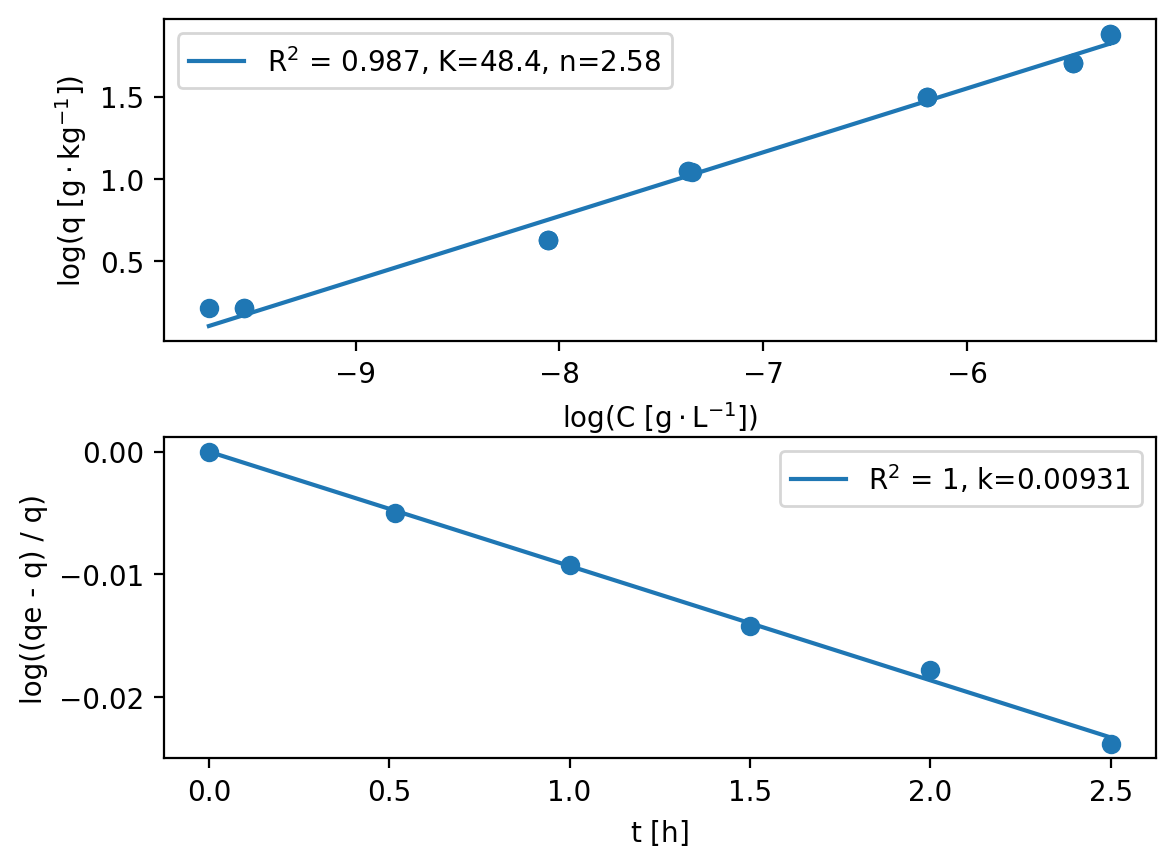

In [1]:
from biosteam import SingleComponentAdsorptionColumn
import matplotlib.pyplot as plt
import biosteam as bst
import numpy as np
import time
Ce = np.array([
    0.06013, 0.07133, 0.07133, 0.31769, 0.31769, 0.31769,
    0.63124, 0.64244, 0.63124, 2.03102, 2.03102, 2.03102,
    4.16988, 4.16988, 4.16988, 5.00974, 4.99854, 4.99854
]) / 1000 # g / L
qe = np.array([
    1.24, 1.24, 1.24, 1.87, 1.87, 1.87, 2.85, 2.84, 2.85,
    4.48, 4.48, 4.48, 5.5, 5.5, 5.5, 6.53, 6.56, 6.56
]) # g / kg
t = np.array([0.0, 31.0, 60.0, 90.0, 120.0, 150.0]) / 60 # h
C = np.array([7.0, 2.45, 1.03, 0.43, 0.26, 0.13]) # g / L
volume = 0.075 # L
adsorbent = 1 # g
fig, axes, parameters = bst.SingleComponentAdsorptionColumn.plot_isotherm_and_mass_transfer_coefficient_fit(
    Ce, qe, t, C, volume, adsorbent, t_units='h', C_units='g/L', q_units='g/kg'
)
plt.show()

Given the superficial velocity (between 4 to 14.4 m/h for liquids) and the feed flow rate, $Q$, we can determine the diameter of the column:

$ D = \sqrt{\frac{4Q} {\pi u}}$

Given the adsorbate concentration in the feed and the cycle time $t_{cycle}$, we can determine the length of the bed in equilibrium (spent) $LES$ in kg / m$^3$:

$ LES = \frac{1000 u t_{cycle} C} {q_e \rho_s}$

The length of unused bed will be given by the mass transfer zone, MTZ, which is based on mass transfer modeling:

$ LUB = \frac{MTZ} {2}$

Finally, let's simulate an adsorption column in BioSTEAM:

In [2]:
import biosteam as bst
bst.nbtutorial()
chemicals = bst.Chemicals([
    'Xylene', 
    bst.Chemical('Ink', search_db=False, default=True, phase='l'),
    bst.Chemical('ActivatedCarbon', search_db=False, default=True, phase='l')
])
bst.settings.set_thermo(chemicals)
chemicals.compile()
feed = bst.Stream(ID='feed', phase='l', T=298, P=1.01e+06,
                  Xylene=1000, Ink=0.001, units='kg/hr')
# Adsorption equilibrium and rate data from Dr. Tianwei Yan from Prof. George Huber's group.
A1 = bst.AdsorptionColumn(
    'A1', ins=feed, outs='effluent',
    cycle_time=1000, # h
    superficial_velocity=4, # m / h
    isotherm_model='Freundlich',
    isotherm_args = (48.4, 2.58), # K, n
    k = 0.00931, # [1 / hr]
    void_fraction=1 - 0.38 / 0.8, 
    C_final_scaled=0.05, # Breakthrough condition
    adsorbate='Ink',
)
A1.simulate()
A1.show()
print()
print(A1.results(basis='SI'))

SingleComponentAdsorptionColumn: A1
ins...
[0] feed  
    phase: 'l', T: 298 K, P: 1.01e+06 Pa
    flow (kmol/hr): Xylene  9.42
                    Ink     0.001
[1] -  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0
[2] -  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): ActivatedCarbon  0.212
outs...
[0] effluent  
    phase: 'l', T: 298 K, P: 101325 Pa
    flow (kmol/hr): Xylene  9.42
[1] -  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0
[2] -  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): ActivatedCarbon  0.212

Single component adsorption column                   Units                   A1
Electricity         Power                               kW                0.273
                    Cost                            USD/hr               0.0214
Design              Diameter                             m                0.602
                    Length                               m                 1.96
                    Vessel type 

In [4]:
import matplotlib.pyplot as plt
from IPython.display import HTML
plt.ioff() # prevent both inline and widget plots 
ani = A1.simulation_gif()
HTML(ani.to_jshtml(15))

## References